In [9]:
import json
import numpy as np
import xobjects as xo
import xtrack as xt
import xpart as xp
from tqdm import tqdm
import matplotlib.pyplot as plt
from scipy import constants 
####################
# Choose a context #
####################
context = xo.ContextCpu()
# context = xo.ContextCpu(omp_num_threads='auto')
buf = context.new_buffer()

# Ion properties:
m_u = 931.49410242e6 # eV/c^2 -- atomic mass unit
A = 207.98 # Lead-208
Z = 82  # Number of protons in the ion (Lead)
Ne = 3 # Number of remaining electrons (Lithium-like)
q0=Z-Ne
m_e = 0.511e6 # eV/c^2 -- electron mass
m_p = 938.272088e6 # eV/c^2 -- proton mass
clight = 299792458.0 # m/s

mass0 = A*m_u + Ne*m_e # eV/c^2
equiv_proton_momentum = 236e9 # eV/c = gamma_p*m_p*v
gamma_p = np.sqrt( 1 + (equiv_proton_momentum/m_p)**2 ) # equvalent gamma for protons in the ring

p0c = equiv_proton_momentum*(Z-Ne) # eV/c
gamma = np.sqrt( 1 + (p0c/mass0)**2 ) # ion relativistic factor
beta_rel = np.sqrt(1-1/(gamma*gamma)) # ion beta


In [10]:
#%%
##################
# Build TrackJob #
##################

fname_sequence ='/home/pkruyt/cernbox/xsuite-env/xtrack/test_data/sps_w_spacecharge/line_no_spacecharge_and_particle.json'

with open(fname_sequence, 'r') as fid:
     input_data = json.load(fid)
sequence = xt.Line.from_dict(input_data['line'])

n_part = int(1e4)

SPS_tracker = xt.Tracker(_context=context, _buffer=buf, line=sequence)

# Build a reference particle
particle_sample = xp.Particles(mass0=mass0, q0=Z-Ne, p0c=p0c,_context=context)

sigma_z = 22.5e-2
nemitt_x = 2e-6
nemitt_y = 2.5e-6


particles = xp.generate_matched_gaussian_bunch(
         num_particles=n_part,
         #total_intensity_particles=bunch_intensity,
         nemitt_x=nemitt_x, nemitt_y=nemitt_y, sigma_z=sigma_z,
         #R_matrix=r_matrix,
         particle_ref=particle_sample,
         tracker=SPS_tracker,
         #,steps_r_matrix=steps_r_matrix,
         )


sequence.particle_ref = particle_sample
twiss = sequence.twiss(symplectify=True)

twiss_dict=dict(twiss)

#%%
###################
# Linear Transfer #
###################

# arc=xt.LinearTransferMatrix(Q_x=twiss['qx'], Q_y=twiss['qy'],
# beta_x_0=twiss['betx'][0], beta_x_1=twiss['betx'][-1],
# beta_y_0=twiss['bety'][0], beta_y_1=twiss['bety'][-1],
# alpha_x_0=twiss['alfx'][0], alpha_x_1=twiss['alfx'][-1],
# alpha_y_0=twiss['alfy'][0], alpha_y_1=twiss['alfy'][-1],
# disp_x_0=twiss['dx'][0], disp_x_1=twiss['dx'][-1],
# disp_y_0=twiss['dy'][0], disp_y_1=twiss['dy'][-1],
# beta_s=twiss['betz0'],
# Q_s=-twiss['qs'],
# chroma_x=twiss['dqx'], chroma_y=twiss['dqy'])


qx=twiss['qx']
qy=twiss['qy']
dqx=twiss['dqx']
dqy=twiss['dqy']
circumference=twiss['s'][-1]
beta_x=twiss['betx'][-1]
beta_y=twiss['bety'][-1]

T = circumference/(clight*beta_rel)
s_per_turn = T

arc = xt.LineSegmentMap(
        qx=qx, qy=qy,
        dqx=0, dqy=0,
        length=circumference,
        betx=beta_x,
        bety=beta_y
        )

# arc = xt.LinearTransferMatrix(
#         Q_x=qx, Q_y=qy,        
#         length=circumference,
#         beta_x_0=twiss['betx'][0], beta_x_1=twiss['betx'][-1],
#         beta_y_0=twiss['bety'][0], beta_y_1=twiss['bety'][-1],
#         _context=context
#         )


Loading line from dict:   0%|          | 0/14704 [00:00<?, ?it/s]

Done loading line from dict.           
Compiling ContextCpu kernels...
Done compiling ContextCpu kernels.
The argument tracker is deprecated. Please use line instead. <class 'DeprecationWarning'>
*** Maximum RMS bunch length 0.23592919520901076m.
... distance to target bunch length: -2.2500e-01
... distance to target bunch length: 4.4112e-03
... distance to target bunch length: 4.1449e-03
... distance to target bunch length: -3.3479e-03
... distance to target bunch length: 1.0467e-03
... distance to target bunch length: 2.0728e-04
... distance to target bunch length: -3.3833e-06
... distance to target bunch length: 4.9353e-08
... distance to target bunch length: -6.5924e-08
--> Bunch length: 0.22500004935312237
--> Emittance: 0.6606168645424672


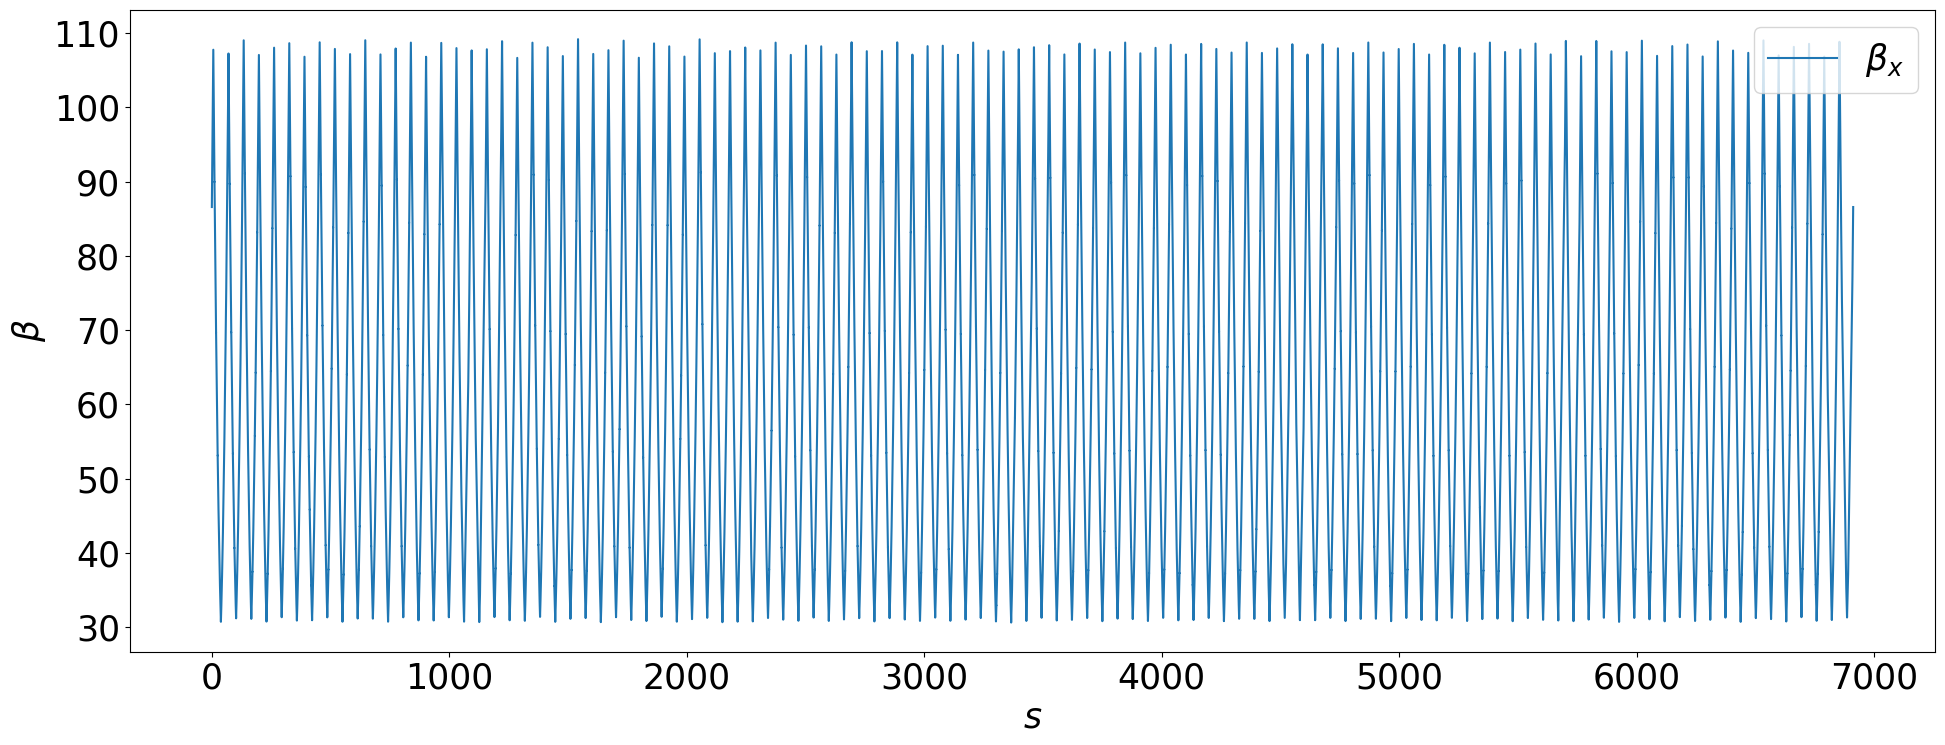

In [11]:
plt.figure(figsize=(20, 8))
plt.rcParams.update({'font.size': 25})
plt.plot(twiss['s'],twiss['betx'],label=r'$\beta_x$')
#plt.plot(twiss['s'],twiss['bety'],label=r'$\beta_y$')
# plt.title(f'width=2*{axis}')
plt.xlabel(r"$s$")
plt.ylabel(r"$\beta$")
plt.legend()
plt.tight_layout()
# plt.ticklabel_format(style='sci', axis='y', scilimits=(0,0))
# plt.ticklabel_format(style='sci', axis='x', scilimits=(0,0))
plt.show()


In [12]:
delta = np.linspace(2.95e-4, 3e-4, n_part)

# # particles.x=0
# # particles.px=0
# # particles.y=0
# # particles.py=0
# particles.delta=delta
# np.std(particles.px)


In [13]:
##################
# Laser Cooler #
##################

sigma_dp = 3e-4 # relative ion momentum spread
#sigma_dp = std_delta # relative ion momentum spread
sigma_dp=np.std(particles.delta.copy())
print('sigma_dp:',sigma_dp*1e3)

#laser-ion beam collision angle
theta_l = 2.6*np.pi/180 # rad
theta_l = 0
nx = 0; ny = -np.sin(theta_l); nz = -np.cos(theta_l)

# Ion excitation energy:
hw0 = 230.823 # eV
hc=constants.hbar*clight/constants.e # eV*m (ħc)
lambda_0 = 2*np.pi*hc/hw0 # m -- ion excitation wavelength

lambda_l = lambda_0*gamma*(1 + beta_rel*np.cos(theta_l)) # m -- laser wavelength

# # Shift laser wavelength for fast longitudinal cooling:
lambda_l = lambda_l*(1+1*sigma_dp) # m

# lambda_l=1034.1703447721 *1e-9

laser_frequency = clight/lambda_l # Hz

print('Laser wavelength = %.2f nm' % (lambda_l/1e-9))
print('Laser wavelength = %.10f nm' % (lambda_l/1e-9))

laser_waist_radius = 2000


laser_x=0.0020000
laser_x=0.000000

gamma0=96

laser_intensity=6790000 #saturation parameter is 7

print('laser_intensity:',laser_intensity)

ion_excited_lifetime=76.6e-12
cooling_section_length=25
GF_IP = xt.CWLaser(_buffer=buf,
                      laser_x=laser_x,
                      laser_y=0,
                      laser_z=0,
                      
                      laser_direction_nx = 0,
                      laser_direction_ny = 0,
                      laser_direction_nz = -1,
                      laser_wavelength = lambda_l, # m
                      laser_waist_radius = laser_waist_radius, # m
                      laser_intensity=laser_intensity,
                      ion_excitation_energy = hw0, # eV
                      ion_excited_lifetime  = ion_excited_lifetime, # sec,
                      cooling_section_length=cooling_section_length
                          
   )
                          


sigma_dp: 0.30036073796307866
Laser wavelength = 1034.17 nm
Laser wavelength = 1034.1734301096 nm
laser_intensity: 6790000


In [14]:
##################
# Tracking #
##################

# simulation parameters: simulate 10 s of cooling, and take data once every 100 ms
max_time_s = 20
int_time_s = 0.1
T_per_turn = circumference/(clight*beta_rel)
num_turns = int(max_time_s/T_per_turn)
save_interval = int(int_time_s/T_per_turn)

# num_turns = int(1e8)
# save_interval = num_turns/100

# create a monitor object, to reduce holded data
monitor = xt.ParticlesMonitor(start_at_turn=0, stop_at_turn=1,
                              n_repetitions=int(num_turns/save_interval),
                              repetition_period=save_interval,
                              num_particles=n_part)

line = xt.Line(
        elements=[monitor,GF_IP, arc])

# line = xt.Line(
#         elements=[monitor,GF_IP])

line.particle_ref = xp.Particles(mass0=mass0, q0=q0, p0c=p0c)
line.build_tracker(_context=context)


line.track(particles, num_turns=num_turns,
              turn_by_turn_monitor=False,with_progress=True)

# extract relevant values
x = monitor.x[:,:,0]
px = monitor.px[:,:,0]
y = monitor.y[:,:,0]
py = monitor.py[:,:,0]
delta = monitor.delta[:,:,0]
state = monitor.state[:,:,0]
time = monitor.at_turn[:, 0, 0] * T_per_turn


Compiling ContextCpu kernels...


6417ccdfd70749be87f3a17bc8264b60.c: In function ‘CWLaser_track_local_particle’:
6417ccdfd70749be87f3a17bc8264b60.c:3525:16: warning: unused variable ‘DeltaDetuningTau’ [-Wunused-variable]
         double DeltaDetuningTau = DeltaDetuning/(2.0*gamma);
                ^~~~~~~~~~~~~~~~


Done compiling ContextCpu kernels.


Tracking:   0%|          | 0/867500 [00:00<?, ?it/s]

In [15]:
# delta = np.linspace(2.97e-4, 2.98e-4, n_part)

# particles = xp.Particles(
#     mass0=mass0,
#     p0c=p0c,
#     q0=Z-Ne,
#     x=0,
#     px=0,
#     y=0,
#     py=0,
#     delta=delta,
#     zeta=0
# )


# ##################
# # Tracking #
# ##################
# x, px,y,py, zeta,accumulated_length,excited_list,delta_list,state_list= [], [],[],[], [], [], [],[],[]
# num_turns = int(1e5) #Lanzhou turns = 103.6*1e6
# save_interval=num_turns/1000
# # loop over turns
# for i in tqdm(range(num_turns)):
#     if i % save_interval ==0:
    
#         x.append(particles.x.copy())
#         px.append(particles.px.copy())
#         x.append(particles.y.copy())
#         py.append(particles.py.copy())
#         # zeta.append(particles.zeta)
#         # accumulated_length.append(particles.s)

#         state=particles.state.copy()
#         state_list.append(state)

#         excited=particles.state==2
#         fraction_excitation = sum(excited)/len(excited)

#         excited_list.append(excited)

#         delta_list.append(particles.delta.copy())
    
#     # track particle
#     #arc.track(particles)
#     GF_IP.track(particles)

# time = np.arange(0, num_turns, save_interval) * s_per_turn    

In [17]:
np.savez('results/CW_data.npz', x=x, px=px, y=y, py=py, delta=delta, state=state, time=time,s_per_turn=s_per_turn)


In [18]:
excited=particles.state==2
fraction_excitation = sum(excited)/len(excited)
print(fraction_excitation)

0.0
